<h1><center>Thinkful Unit 4 Capstone: Blog Author Identification</h1>

## Introduction

This report will focus on using both clustering and supervised learning models to classify blog posts by author. Data are taken from the Blog Authorship Corpus (https://u.cs.biu.ac.il/~koppel/BlogCorpus.htm), a collection of over 680k posts from over 19k bloggers taken from blogger.com in August 2004. This study will focus on longer blog posts that should contain more identifiable features than short one or two sentence posts.

The spaCy NLP library will be used for tokenizing and two methods of vectorization will be used:
- Bag of Words (BoW)
- Term Frequency-Inverse Document Frequency (tf-idf)

Three clustering methods will be compared:
- K-Means
- Mean-Shift
- Spectral Clustering

Dimensionality reduction will be applied via:
- truncated SVD (i.e. latent semantic analysis)
- PCA

Three supervised learning models will be used:
- Random Forest
- Linear SVC
- Gradient Boosting

Once initial models have been tested, the best clustering method and the best supervised learning model will be explored in greater depth to try to optimize each and determine the best method of author classification.

## Data Preparation

#### Load libraries

In [1]:
import pandas as pd
import scipy
import numpy as np
import math
import datetime

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

#### Load CSV 

In [2]:
df0 = pd.read_csv('../data/blogtext.csv', delimiter=',',usecols=['id','topic','date','text'])
df0.dataframeName = 'blogtext.csv'
nRow, nCol = df0.shape
print(f'There are {nRow} total blog entries.')

There are 681284 total blog entries.


#### Data Cleaning

Drop duplicates

In [3]:
df0.drop_duplicates(subset="text",inplace=True)

Remove blogs using non-English months in their date fields.

In [4]:
date_strings = df0['date'].str.title()
english_month = (date_strings.str.contains(',January,')) | (date_strings.str.contains(',February,')) | \
               (date_strings.str.contains(',March,')) | (date_strings.str.contains(',April,')) | \
               (date_strings.str.contains(',May,')) | (date_strings.str.contains(',June,')) | \
               (date_strings.str.contains(',July,')) | (date_strings.str.contains(',August,')) | \
               (date_strings.str.contains(',September,')) | (date_strings.str.contains(',October,')) | \
               (date_strings.str.contains(',November,')) | (date_strings.str.contains(',December,'))
df = df0.drop(df0[~english_month].index)

In [5]:
df['datetime'] = pd.to_datetime(df['date'].str.title(), format='%d,%B,%Y')
df = df.drop(columns=['date'])
nRow, nCol = df.shape
print(f'After filtering for English months, there are {nRow} remaining blog entries.')

After filtering for English months, there are 604518 remaining blog entries.


#### Filter blog entries

Count number of characters per post

In [6]:
df['char_count'] = [ len(t) for t in df['text'] ]

(array([379154., 128215.,  49804.,  21554.,  10691.,   5658.,   3191.,
          1826.,   1209.,    783.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <a list of 10 Patch objects>)

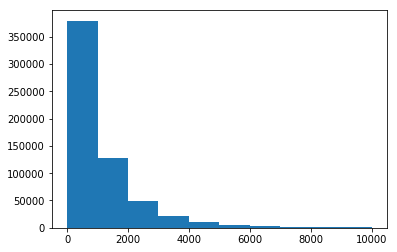

In [7]:
plt.hist(df['char_count'],range = (0,10000))

Select only posts at least 5000 characters long

In [8]:
df = df[df['char_count'] >= 5000]

Count number of posts by author and topic

In [9]:
post_count = df.groupby('id').size()
df['post_count'] = [ post_count[id] for id in df['id'] ]

In [10]:
topic_count = df.groupby('topic').size()
df['topic_count'] = [ topic_count[topic] for topic in df['topic'] ]

In [11]:
topic_count.sort_values(ascending=False)

topic
indUnk                     5203
Student                    3021
Education                   943
Arts                        814
Technology                  679
Communications-Media        606
Publishing                  424
Internet                    392
Non-Profit                  334
Engineering                 275
Law                         234
Consulting                  233
Science                     169
BusinessServices            149
Government                  131
Accounting                  116
Military                    109
Sports-Recreation           108
Advertising                 102
Religion                     96
Telecommunications           91
Manufacturing                89
RealEstate                   80
Banking                      78
Marketing                    71
HumanResources               67
Tourism                      63
Fashion                      54
Transportation               53
Museums-Libraries            51
LawEnforcement-Security      45
Bi

Of the identified topics, the most heavily posted is 'Student' so focus on those posts

In [12]:
df = df[df['topic'] == 'Student']

Focus on authors with the highest number of longer posts

{'whiskers': [<matplotlib.lines.Line2D at 0x2190e543438>,
 'caps': [<matplotlib.lines.Line2D at 0x2190e519ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2190e519438>],
 'medians': [<matplotlib.lines.Line2D at 0x2190f5125c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2190f512908>],
 'means': []}

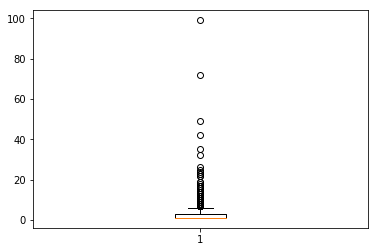

In [13]:
plt.boxplot(df.groupby('id').size())

Select only authors with at least 20 posts.

In [14]:
df = df[df['post_count'] >= 20]

In [15]:
blogger_ids = pd.unique(df['id']).astype(str)
len(df.groupby('id').size())

13

In [16]:
len(df)

494

There are 13 remaining authors with a total of 494 posts.

#### Clean up DataFrame

In [17]:
df = df.drop(columns = ['topic','datetime','post_count','topic_count','char_count'])
df = df.reset_index(drop=True)
#df.to_csv('reduced_blog_corpus.csv')

del df0

In [18]:
df.head(5)

,id,text
0,780903,"Wednesday's observations, one..."
1,780903,Not sure if I've mentioned in...
2,780903,I had an interesting conversa...
3,780903,No snow on the ground here in...
4,780903,There's another weblog out th...


## Data Processing

#### Process posts with spaCy

The spaCy NLP library contains a good set of models that include contextual information and stop words so will be used for tokenization.

In [19]:
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Get spaCy stopwords
nlp = spacy.load('c:/users/yfsta/anaconda3/lib/site-packages/en_core_web_lg/en_core_web_lg-2.1.0')
stop_words = list(spacy.lang.en.stop_words.STOP_WORDS)

In [20]:
# Initialize English parser
parser = English()

# Create spaCy tokenizer
def spacy_tokenizer(sentence):
    
    # Create tokens object from parser
    tokens = nlp(sentence)
#    tokens = parser(sentence)

    # Remove words not included in NLP vocab list (oov = out of vocabulary)
#    tokens = [ t for t in tokens if t.is_oov is False ]
    
    # Exclusion list
    exclusion_list = list(string.punctuation)
    exclusion_list.extend(list(stop_words))
    
    # Lemmatize, convert to lowercase and remove extra spaces
    tokens = [ w.lemma_.lower().strip() for w in tokens if w.lemma_ not in exclusion_list ]
    
    return tokens

#### Bag of Words (BoW) Vectorization

Bag of Words uses word counts for vectorization. Since it does not taken into account term frequency within the corpus, the stop word list is necessary to prevent common words from having too much influence.  

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [22]:
bow_out = bow_vector.fit_transform(df['text'])

In [23]:
bow_train, bow_test, Y_train0, Y_test0 = train_test_split(bow_out,df['id'],
                                                          test_size=0.25, random_state=42)

In [24]:
print('The dimensions of the BoW training set are: ' + str(bow_train.shape))
print('The dimensions of the BoW test set are: ' + str(bow_test.shape))

The dimensions of the BoW training set are: (370, 24992)
The dimensions of the BoW test set are: (124, 24992)


In [25]:
from sklearn.preprocessing import normalize

bow_train_out = normalize(bow_train)
bow_test_out = normalize(bow_test)

#### tf-idf Vectorization

Like BoW, tf-idf vectorization is based upon word count within each document. However, as its name indicates, it applies a penalty to each term based on how frequently it occurs within the corpus, thus giving less weight to common words. The stop word list filter is applied as well but the inverse document frequency penalty adds an additional layer.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, sublinear_tf=True, use_idf=True)

In [27]:
tfidf_out = tfidf_vector.fit_transform(df['text'])

In [28]:
tfidf_train, tfidf_test, Y_train, Y_test = train_test_split(tfidf_out,df['id'],
                                                            test_size=0.25, random_state=42)

In [29]:
print('The dimensions of the tf-idf training set are: ' + str(tfidf_train.shape))
print('The dimensions of the tf-idf test set are: ' + str(tfidf_test.shape))

The dimensions of the tf-idf training set are: (370, 24992)
The dimensions of the tf-idf test set are: (124, 24992)


In [30]:
tfidf_train_out = normalize(tfidf_train)
tfidf_test_out = normalize(tfidf_test)

## Clustering

Three clustering methods will be used. K-Means and Spectral Clustering take target clusters as an input and will be set to 13 while Mean Shift will be allowed to estimate clusters on its own.

#### K-Means

In [31]:
from sklearn.cluster import KMeans

# Initialize and fit K-Means
bow_full_pred = KMeans(n_clusters=13, random_state=42).fit_predict(bow_train_out)

# Check actual vs. predicted
pd.crosstab(Y_train, bow_full_pred)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12
id,,,,,,,,,,,,,
670684,13,0,1,0,0,0,0,3,0,0,0,0,0
780903,18,0,0,0,11,0,1,22,0,1,0,0,0
1474573,6,0,5,0,0,0,0,2,2,0,0,0,4
1516660,0,0,1,0,0,0,1,0,19,0,0,0,9
1593902,3,0,4,0,0,0,0,2,2,0,0,2,9
1889734,13,0,0,0,0,0,0,10,4,0,0,0,5
2128831,4,0,3,0,0,0,0,0,9,0,0,0,6
2155904,2,0,0,0,0,37,0,0,1,0,0,0,0
2314011,13,0,1,0,0,0,0,3,0,0,0,0,1


In [32]:
from sklearn import metrics
    
bow_kmeans_ari = metrics.adjusted_rand_score(Y_train, bow_full_pred)

print('ARI for K-Means BoW is: ' + str(bow_kmeans_ari))

ARI for K-Means BoW is: 0.2797914250647057


K-Means BoW does fairly well for many of the topics but struggles for others.

In [33]:
# Initialize and fit K-Means
tfidf_full_pred = KMeans(n_clusters=13, random_state=42).fit_predict(tfidf_train_out)

# Check actual vs predicted
pd.crosstab(Y_train, tfidf_full_pred)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12
id,,,,,,,,,,,,,
670684,1,0,0,0,0,0,0,2,0,14,0,0,0
780903,0,0,0,14,0,0,25,11,0,3,0,0,0
1474573,0,0,0,0,0,1,0,6,0,12,0,0,0
1516660,0,0,0,0,0,0,0,0,0,1,0,29,0
1593902,2,0,0,0,0,1,1,7,0,10,0,0,1
1889734,0,0,0,0,0,4,0,21,0,0,0,0,7
2128831,0,0,0,0,0,4,0,4,1,13,0,0,0
2155904,0,39,0,0,0,0,0,0,0,1,0,0,0
2314011,0,0,0,0,0,0,0,0,1,17,0,0,0


In [34]:
tfidf_kmeans_ari = metrics.adjusted_rand_score(Y_train, tfidf_full_pred)

print('ARI for K-Means tf-idf is: ' + str(tfidf_kmeans_ari))

ARI for K-Means tf-idf is: 0.41365769587875706


K-Means tf-idf performs considerably better than BoW and has fewer ambiguous columns.

#### Mean-Shift

Although Mean-Shift is not commonly used for NLP and is more often used for image processing, it is a clustering method that does not require a target number of clusters so will be tested to see if it can correctly predict number of clusters and the clusters themselves.

In [35]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [36]:
print("BoW Mean-Shift:")

# Estimate bandwidth based on data
bandwidth = estimate_bandwidth(bow_train_out.toarray(), quantile=0.5,
                               n_samples=100, n_jobs=-1, random_state=42)

print("Estimated bandwidth: {}".format(bandwidth))

# Initialize and fit model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms.fit(bow_train_out.toarray())

# Extract cluster assignments for each data point
labels = ms.labels_

# Count our clusters
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Predict clusters
bow_full_pred = ms.predict(bow_train_out.toarray())

BoW Mean-Shift:
Estimated bandwidth: 0.547011970119852
Number of estimated clusters: 5


In [37]:
# Check actual vs predicted
pd.crosstab(Y_train, bow_full_pred)

bow_mean_shift_ari = metrics.adjusted_rand_score(Y_train, bow_full_pred)

print('ARI for Mean-Shift BoW is: ' + str(bow_mean_shift_ari))

ARI for Mean-Shift BoW is: 0.0016178059129852553


Mean-shift BoW does not perform well. Since the predicted bandwidth only yields 5 estimated clusters, this is not surprising.

In [38]:
print("tf-idf Mean-Shift:")

# Estimate bandwidth based on data
bandwidth = estimate_bandwidth(tfidf_train_out.toarray(), quantile=0.5,
                               n_samples=100, n_jobs=-1, random_state=42)

print("Estimated bandwidth: {}".format(bandwidth))
# Initialize and fit model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms.fit(tfidf_train_out.toarray())

# Extract cluster assignments for each data point
labels = ms.labels_

# Coordinates of the cluster centers
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Predict clusters
tfidf_full_pred = ms.predict(tfidf_train_out.toarray())

tf-idf Mean-Shift:
Estimated bandwidth: 1.3605898798037976
Number of estimated clusters: 1


The estimated bandwidth for tf-idf does not yield any distinct clusters so explicitly setting bandwidth is necessary.

In [39]:
print("tf-idf Mean-Shift:")

# Initialize and fit model
ms = MeanShift(bandwidth=0.175, bin_seeding=True, n_jobs=-1)
ms.fit(tfidf_train_out.toarray())

# Extract cluster assignments for each data point
labels = ms.labels_

# Coordinates of the cluster centers
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Predict clusters
tfidf_full_pred = ms.predict(tfidf_train_out.toarray())

tf-idf Mean-Shift:
Number of estimated clusters: 370


Explicitly setting bandwidth to 0.175 generates 370 clusters = total number of points so it does not seem like Mean-Shift works for tf-idf in this scenario.

#### Spectral Clustering

In [40]:
from sklearn.cluster import SpectralClustering

# Declare and fit the model
sc = SpectralClustering(n_clusters=13, random_state=42, n_jobs=-1)
sc.fit(bow_train_out)

#Predict clusters
bow_full_pred = sc.fit_predict(bow_train_out)

In [41]:
# Check actual vs predicted
print(pd.crosstab(Y_train,bow_full_pred))

bow_sc_ari = metrics.adjusted_rand_score(Y_train, bow_full_pred)

print('ARI for Spectral Clustering BoW is: ' + str(bow_sc_ari))

col_0    0   1   2   3   4   5   6   7   8   9   10  11  12
id                                                         
670684    0   0   0   0   0   0   0   1   0  13   0   3   0
780903    0   0   1   0   0  15   0   2   1  15   0  19   0
1474573   0   4   0   0   0   0   0   0   0  13   0   2   0
1516660   0   1   0   0   0   0   0   0   0   1  28   0   0
1593902   0  12   0   2   0   0   0   2   0   4   0   1   1
1889734   0   9   0   0   0   0   0   2   0  15   0   6   0
2128831   0  15   0   0   0   0   0   2   0   5   0   0   0
2155904  37   0   0   0   0   0   0   0   0   2   0   1   0
2314011   0   1   0   0   0   0   0   0   0  15   0   2   0
2587254   0   3   0   0  34   0  11   0   2   0   0   0  16
2862338   0   2  16   0   0   0   0   0   2   0   0   0   0
3305548   0   9   0   0   0   0   0   2   0   0   0   0   0
4161674   0  11   0   0   0   0   0   5   0   3   0   1   0
ARI for Spectral Clustering BoW is: 0.32166307042238124


Spectral clustering BoW performs slightly better than K-Means with an ARI of 0.32 vs. 0.28.

In [42]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=13, random_state=42, n_jobs=-1)
sc.fit(tfidf_train_out)

#Predict clusters
tfidf_full_pred = sc.fit_predict(tfidf_train_out)

In [43]:
# Check actual vs predicted
print(pd.crosstab(Y_train,tfidf_full_pred))

tfidf_sc_ari = metrics.adjusted_rand_score(Y_train, tfidf_full_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_ari))

col_0    0   1   2   3   4   5   6   7   8   9   10  11  12
id                                                         
670684    6   0   0   0   0   0   0   9   0   1   1   0   0
780903    2   0  42   0   0   0   0   1   0   2   0   5   1
1474573   1   0   0   0   0   0   0  16   0   0   1   0   1
1516660   1   0   0  29   0   0   0   0   0   0   0   0   0
1593902   0   0   0   0   0   0   0  17   0   3   1   0   1
1889734   2   0   0   0   0   0   0   1   0   8  18   0   3
2128831   0   0   0   0   0   0   0  19   0   0   2   0   1
2155904   2  18   0   0   0   0  19   1   0   0   0   0   0
2314011  15   0   0   0   0   0   0   1   0   2   0   0   0
2587254   0   0   0   0   0  28   0   0  38   0   0   0   0
2862338   0   0   0   0  18   0   0   2   0   0   0   0   0
3305548   0   0   0   0   0   0   0   1   0   1   1   1   7
4161674   1   0   0   0   0   0   0   8   0   0   0   0  11
ARI for Spectral Clustering tf-idf is: 0.5047809143315318


Spectral clustering tf-idf performs considerably better than BoW and surpasses K-Means tf-idf with an ARI of 0.50 vs. 0.41.

#### Clustering Comparison

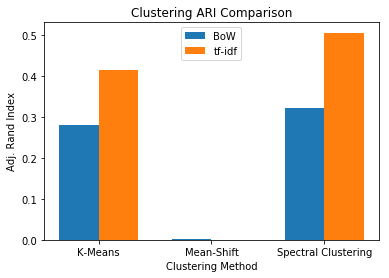

In [44]:
x = np.arange(3)
labels = [ 'K-Means', 'Mean-Shift', 'Spectral Clustering']
bow_data = [ bow_kmeans_ari, bow_mean_shift_ari, bow_sc_ari]
tfidf_data = [ tfidf_kmeans_ari, 0, tfidf_sc_ari]

fig, ax = plt.subplots()
bar_width = 0.35

rects1 = ax.bar(x - bar_width/2, bow_data, bar_width, label='BoW')
rects2 = ax.bar(x + bar_width/2, tfidf_data, bar_width, label='tf-idf')

ax.set_title('Clustering ARI Comparison')
ax.set_xlabel('Clustering Method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Adj. Rand Index')
ax.legend(loc=9)
plt.show()

Spectral Clustering performed best among these clustering methods, followed by K-Means. Mean-Shift was not viable and could not correctly predict the number of clusters. In terms of vectorization method, tf-idf outperformed BoW.

## Unsupervised Feature Generation

Two methods will be used to reduce dimensionality: truncated SVD and PCA. An 80% threshold will be used to determine number of components to be used. This level was chosen to balance lower number of components with relatively high variance explained. Less components might be viable but would be at a trade off against variance explained and vice versa.

Two component SVD and PCA will also be calculated for later possible use in visualization but will not be used directly in any models.

#### Reduce dimensionality using truncated SVD

In [45]:
from sklearn.decomposition import TruncatedSVD

In [46]:
bow_svd = TruncatedSVD(100).fit(bow_train_out)
lsa_bow_train = bow_svd.transform(bow_train_out)
lsa_bow_test = bow_svd.transform(bow_test_out)

variance_explained = bow_svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance of BoW training set captured by all components:",total_variance*100)

Percent variance of BoW training set captured by all components: 80.52443577044083


Using k=100 yields a BoW training set SVD percent variance explained of 80.5%.

In [47]:
tfidf_svd= TruncatedSVD(270).fit(tfidf_train_out)
lsa_tfidf_train = tfidf_svd.transform(tfidf_train_out)
lsa_tfidf_test = tfidf_svd.transform(tfidf_test_out)

variance_explained=tfidf_svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance tf-idf training captured by all components:",total_variance*100)

Percent variance tf-idf training captured by all components: 80.8198554505519


Using k=270 yields a tf-idf training set SVD percent variance explained of 80.8%.

#### Reduce dimensionality using PCA

In [48]:
from sklearn.decomposition import PCA
from regressors import plots

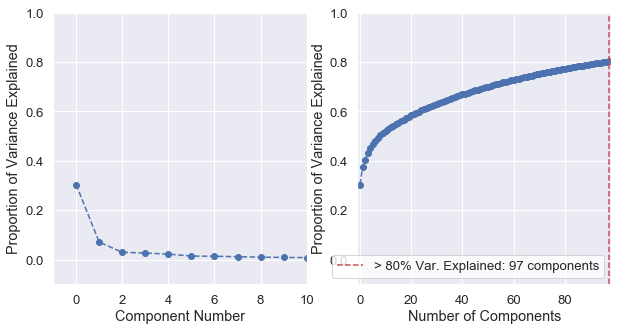

In [49]:
pca_bow = PCA(n_components=100).fit(bow_train_out.toarray())
plots.plot_scree(pca_bow, required_var=0.8)
pca_bow_train = pca_bow.transform(bow_train_out.toarray())
pca_bow_test = pca_bow.transform(bow_test_out.toarray())

The 80% variance explained level can be reached using 97 principal components for the BoW training set. This is similar to the 100 components needed for SVD.

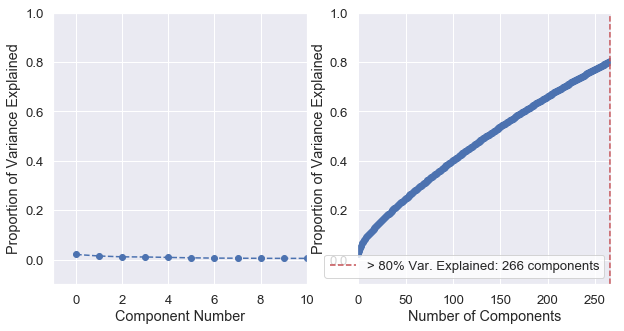

In [50]:
pca_tfidf = PCA(n_components=275).fit(tfidf_train_out.toarray())
plots.plot_scree(pca_tfidf, required_var=0.8)
pca_tfidf_train = pca_tfidf.transform(tfidf_train_out.toarray())
pca_tfidf_test = pca_tfidf.transform(tfidf_test_out.toarray())

The 80% variance explained level can be reached using 266 principal components for the tf-idf training set. This is similar to the 270 components needed for SVD.

#### Apply Two-Component PCA for Later Visualization

Even though PCA and LSA can vastly reduce number of dimensions without losing too much information, visualizing on even five components, much less 100, is difficult. For visualization purposes only, a two component PCA transformation will be used to generate scatter plots for comparison. The larger PCA sets will still be used when applying supervised learning models upon the data, however.

In [51]:
pca_bow2 = PCA(n_components=2).fit(bow_train_out.toarray())
pca_bow_train2 = pca_bow2.transform(bow_train_out.toarray())
pca_bow_test2 = pca_bow2.transform(bow_test_out.toarray())

pca_tfidf2 = PCA(n_components=2).fit(tfidf_train_out.toarray())
pca_tfidf_train2 = pca_tfidf2.transform(tfidf_train_out.toarray())
pca_tfidf_test2 = pca_tfidf2.transform(tfidf_test_out.toarray())

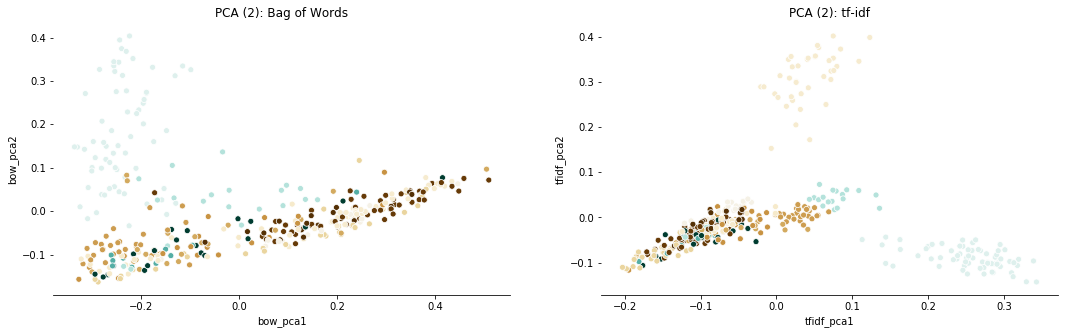

In [52]:
pca2_chart = pd.DataFrame()
pca2_chart['bow_pca1'] = pca_bow_train2[:,0]
pca2_chart['bow_pca2'] = pca_bow_train2[:,1]
pca2_chart['tfidf_pca1'] = pca_tfidf_train2[:,0]
pca2_chart['tfidf_pca2'] = pca_tfidf_train2[:,1]
pca2_chart['id'] = Y_train.values

f, axes = plt.subplots(1, 2, figsize=(18,5), sharex=False)
sns.despine(left=True)

sns.scatterplot(x='bow_pca1', y='bow_pca2', hue='id', data=pca2_chart, palette='BrBG',
                legend=None, ax=axes[0]).set_title('PCA (2): Bag of Words')
sns.scatterplot(x='tfidf_pca1', y='tfidf_pca2', hue='id', data=pca2_chart, palette='BrBG',
                legend=None, ax=axes[1]).set_title('PCA (2): tf-idf')
plt.show()

Two component-PCA does not consistently separate data for either BoW or tf-idf but both do show some distinct clusters. Notably, tf-idf has four separate clusters with all other data relatively mixed. BoW seems more mixed but does isolate out one fairly large cluster.

#### Conclusion

Since tf-idf benefits from retaining sparsity, latent semantic analysis (LSA) via truncated SVD will be used for testing the dimensionally reduced set. For contrast, PCA will be used for BoW.

## Supervised Learning Models

Three types of supervised learning models will be compared: Random Forest, Linear SVC and Gradient Boosting. First, each model will be run using the full set of training data. Next, each model will be re-run using dimensionally reduced data, using PCA for BoW and LSA for tf-idf.

#### Random Forest

In [53]:
from sklearn import ensemble
from sklearn.metrics import classification_report, f1_score

print('BoW Random Forest:')
bow_rfc = ensemble.RandomForestClassifier(n_estimators=100)
bow_rfc_train = bow_rfc.fit(bow_train_out, Y_train)

Y_pred = bow_rfc.predict(bow_test_out)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
bow_rfc_test_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

print('tf-idf Random Forest:')
tfidf_rfc = ensemble.RandomForestClassifier(n_estimators=100)
tfidf_rfc_train = tfidf_rfc.fit(tfidf_train_out, Y_train)

Y_pred = tfidf_rfc.predict(tfidf_test_out)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
tfidf_rfc_test_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

BoW Random Forest:
              precision    recall  f1-score   support

      780903       1.00      0.60      0.75         5
     3305548       0.51      1.00      0.68        19
     2155904       0.00      0.00      0.00         3
     1474573       1.00      1.00      1.00         5
     4161674       0.50      0.33      0.40         3
     2314011       0.54      0.70      0.61        10
     1889734       0.71      0.50      0.59        10
      670684       1.00      1.00      1.00         9
     1593902       1.00      0.60      0.75         5
     2128831       0.97      1.00      0.99        33
     1516660       1.00      1.00      1.00         6
     2862338       1.00      0.08      0.15        12
     2587254       0.33      0.25      0.29         4

    accuracy                           0.75       124
   macro avg       0.74      0.62      0.63       124
weighted avg       0.80      0.75      0.72       124

tf-idf Random Forest:
              precision    recall  f1-

Accuracy and F1 scores are about the same for both BoW and tf-idf Random Forest with accuracy between 0.76-0.77 and weighted F1 scores of 0.73. However, two authors have no correctly identified posts for Random Forest and one author for tf-idf.

In [54]:
print('BoW Random Forest (PCA):')
bow_rfc = ensemble.RandomForestClassifier(n_estimators=100)
bow_rfc_train = bow_rfc.fit(pca_bow_train, Y_train)

Y_pred = bow_rfc.predict(pca_bow_test)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
bow_rfc_test_score_pca = metrics.f1_score(Y_test, Y_pred, average='weighted')

print('tf-idf Random Forest (LSA):')
tfidf_rfc = ensemble.RandomForestClassifier(n_estimators=100)
tfidf_rfc_train = tfidf_rfc.fit(lsa_tfidf_train, Y_train)

Y_pred = tfidf_rfc.predict(lsa_tfidf_test)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
tfidf_rfc_test_score_lsa = metrics.f1_score(Y_test, Y_pred, average='weighted')

BoW Random Forest (PCA):
              precision    recall  f1-score   support

      780903       1.00      0.80      0.89         5
     3305548       0.73      0.84      0.78        19
     2155904       0.00      0.00      0.00         3
     1474573       0.83      1.00      0.91         5
     4161674       0.50      1.00      0.67         3
     2314011       0.83      0.50      0.62        10
     1889734       0.70      0.70      0.70        10
      670684       0.90      1.00      0.95         9
     1593902       0.67      0.80      0.73         5
     2128831       0.89      1.00      0.94        33
     1516660       0.86      1.00      0.92         6
     2862338       1.00      0.42      0.59        12
     2587254       0.67      0.50      0.57         4

    accuracy                           0.80       124
   macro avg       0.74      0.74      0.71       124
weighted avg       0.81      0.80      0.78       124

tf-idf Random Forest (LSA):
              precision   

When switching to the dimensionally reduced sets, BoW w/ PCA performs considerably better than tf-idf w/ LSA and slightly better than using the original data.

#### Linear SVC

In [55]:
from sklearn.svm import LinearSVC

print('BoW Linear SVC:')
bow_svc = LinearSVC()
bow_svc_train = bow_svc.fit(bow_train_out, Y_train)

Y_pred = bow_svc.predict(bow_test_out)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
bow_svc_test_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

print('tf-idf Linear SVC:')
tfidf_svc = LinearSVC()
tfidf_svc_train = tfidf_svc.fit(tfidf_train_out, Y_train)

Y_pred = tfidf_svc.predict(tfidf_test_out)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
tfidf_svc_test_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

BoW Linear SVC:
              precision    recall  f1-score   support

      780903       1.00      0.60      0.75         5
     3305548       0.70      1.00      0.83        19
     2155904       0.00      0.00      0.00         3
     1474573       0.71      1.00      0.83         5
     4161674       1.00      0.67      0.80         3
     2314011       0.89      0.80      0.84        10
     1889734       0.80      0.80      0.80        10
      670684       1.00      1.00      1.00         9
     1593902       1.00      0.60      0.75         5
     2128831       0.97      1.00      0.99        33
     1516660       0.60      1.00      0.75         6
     2862338       1.00      0.50      0.67        12
     2587254       0.75      0.75      0.75         4

    accuracy                           0.85       124
   macro avg       0.80      0.75      0.75       124
weighted avg       0.86      0.85      0.83       124

tf-idf Linear SVC:
              precision    recall  f1-score 

Although Linear SVC performs well for BoW with accuracy of 0.85 and weighted F1 score of 0.83, it performs even better with tf-idf with accuracy of 0.93 and F1 score of 0.83. Precision and recall was at least 0.60 for all authors for tf-idf, while there was one author for the BoW model that had no correctly identified posts and another and five authors with recall < 0.7.

In [56]:
print('BoW Linear SVC (PCA):')
bow_svc = LinearSVC()
bow_svc_train = bow_svc.fit(pca_bow_train, Y_train)

Y_pred = bow_svc.predict(pca_bow_test)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
bow_svc_test_score_pca = metrics.f1_score(Y_test, Y_pred, average='weighted')

print('tf-idf Linear SVC (LSA):')
tfidf_svc = LinearSVC()
tfidf_svc_train = tfidf_svc.fit(lsa_tfidf_train, Y_train)

Y_pred = tfidf_svc.predict(lsa_tfidf_test)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
tfidf_svc_test_score_lsa = metrics.f1_score(Y_test, Y_pred, average='weighted')

BoW Linear SVC (PCA):
              precision    recall  f1-score   support

      780903       1.00      0.40      0.57         5
     3305548       0.70      1.00      0.83        19
     2155904       0.00      0.00      0.00         3
     1474573       0.71      1.00      0.83         5
     4161674       0.67      0.67      0.67         3
     2314011       0.80      0.80      0.80        10
     1889734       0.80      0.80      0.80        10
      670684       1.00      1.00      1.00         9
     1593902       1.00      0.40      0.57         5
     2128831       0.97      1.00      0.99        33
     1516660       0.60      1.00      0.75         6
     2862338       1.00      0.50      0.67        12
     2587254       0.75      0.75      0.75         4

    accuracy                           0.83       124
   macro avg       0.77      0.72      0.71       124
weighted avg       0.84      0.83      0.81       124

tf-idf Linear SVC (LSA):
              precision    recal

Results using the reduced data sets were similar, although the BoW w/ PCA performed slightly worse.

#### Gradient Boosting

In [57]:
print('BoW Gradient Boosting:')
bow_gbc = ensemble.GradientBoostingClassifier()
bow_gbc_train = bow_gbc.fit(bow_train_out, Y_train)

Y_pred = bow_gbc.predict(bow_test_out)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
bow_gbc_test_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

print('tf-idf Gradient Boosting:')
tfidf_gbc = ensemble.GradientBoostingClassifier()
tfidf_gbc_train = tfidf_gbc.fit(tfidf_train_out, Y_train)

Y_pred = tfidf_gbc.predict(tfidf_test_out)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
tfidf_gbc_test_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

BoW Gradient Boosting:
              precision    recall  f1-score   support

      780903       0.75      0.60      0.67         5
     3305548       0.84      0.84      0.84        19
     2155904       0.75      1.00      0.86         3
     1474573       1.00      1.00      1.00         5
     4161674       0.00      0.00      0.00         3
     2314011       0.62      0.80      0.70        10
     1889734       0.53      0.80      0.64        10
      670684       1.00      1.00      1.00         9
     1593902       0.80      0.80      0.80         5
     2128831       1.00      0.94      0.97        33
     1516660       1.00      1.00      1.00         6
     2862338       1.00      0.58      0.74        12
     2587254       0.25      0.25      0.25         4

    accuracy                           0.81       124
   macro avg       0.73      0.74      0.73       124
weighted avg       0.83      0.81      0.82       124

tf-idf Gradient Boosting:
              precision    rec

Both BoW and tf-idf performed relatively well using Gradient Boosting with BoW having slightly higher accuracy and weighted F1 score. Neither were able to correctly identify posts by one author (4161674).

In [58]:
print('BoW Gradient Boosting (PCA):')
bow_gbc = ensemble.GradientBoostingClassifier()
bow_gbc_train = bow_gbc.fit(pca_bow_train, Y_train)

Y_pred = bow_gbc.predict(pca_bow_test)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
bow_gbc_test_score_pca = metrics.f1_score(Y_test, Y_pred, average='weighted')

print('tf-idf Gradient Boosting (LSA):')
tfidf_gbc = ensemble.GradientBoostingClassifier()
tfidf_gbc_train = tfidf_gbc.fit(lsa_tfidf_train, Y_train)

Y_pred = tfidf_gbc.predict(lsa_tfidf_test)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
tfidf_gbc_test_score_lsa = metrics.f1_score(Y_test, Y_pred, average='weighted')

BoW Gradient Boosting (PCA):
              precision    recall  f1-score   support

      780903       0.30      0.60      0.40         5
     3305548       0.71      0.79      0.75        19
     2155904       0.00      0.00      0.00         3
     1474573       1.00      1.00      1.00         5
     4161674       0.27      1.00      0.43         3
     2314011       0.46      0.60      0.52        10
     1889734       0.62      0.50      0.56        10
      670684       1.00      1.00      1.00         9
     1593902       0.60      0.60      0.60         5
     2128831       0.97      0.94      0.95        33
     1516660       0.83      0.83      0.83         6
     2862338       0.00      0.00      0.00        12
     2587254       1.00      0.50      0.67         4

    accuracy                           0.70       124
   macro avg       0.60      0.64      0.59       124
weighted avg       0.68      0.70      0.68       124

tf-idf Gradient Boosting (LSA):
              prec

Performance of the Gradient Boosting models dropped when using the reduced sets. Interestingly, the author that had no correctly identified posts using the original data (4161674) had some correctly identified posts for both BoW w/ PCA and tf-idf w/ LSA. However, a new author (2862338) had no correctly identified posts in either model and the tf-idf model could not correctly identify posts by three other authors (although it had seven authors with perfect precision).

#### Comparison

Weighted F1 scores will be compared between these models to determine which performed best. Since there is some imbalance in the number of posts per author, weighted F1 score may be a better metric than accuracy, which can be skewed by class imbalances.

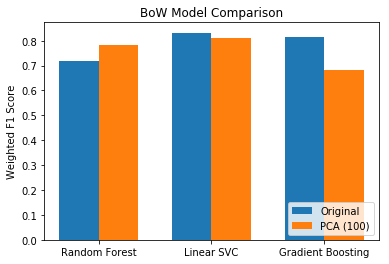

In [59]:
x = np.arange(3)
labels = [ 'Random Forest', 'Linear SVC', 'Gradient Boosting']
original_data = [ bow_rfc_test_score, bow_svc_test_score, bow_gbc_test_score ]
rd_data = [bow_rfc_test_score_pca, bow_svc_test_score_pca, bow_gbc_test_score_pca ]

fig, ax = plt.subplots()
bar_width = 0.35

rects1 = ax.bar(x - bar_width/2, original_data, bar_width, label='Original')
rects2 = ax.bar(x + bar_width/2, rd_data, bar_width, label='PCA (100)')

ax.set_title('BoW Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Weighted F1 Score')
ax.legend(loc=4)
plt.show()

All of the BoW supervised learning models had weighted F1 scores of at least 0.70. Adding 100 component PCA reduced F1 score for Linear SVC and Gradient Boosting but raised it significantly for Random Forest. Although Random Forest w/ PCA performed very well, Random Forest w/o PCA did not perform as well and Linear SVC perfomed best on average.

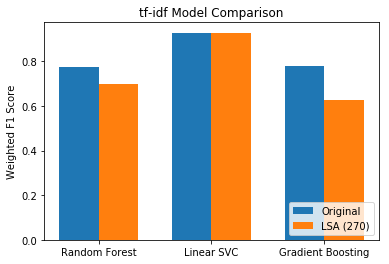

In [60]:
x = np.arange(3)
labels = [ 'Random Forest', 'Linear SVC', 'Gradient Boosting']
original_data = [ tfidf_rfc_test_score, tfidf_svc_test_score, tfidf_gbc_test_score ]
rd_data = [tfidf_rfc_test_score_lsa, tfidf_svc_test_score_lsa, tfidf_gbc_test_score_lsa ]

fig, ax = plt.subplots()
bar_width = 0.35

rects1 = ax.bar(x - bar_width/2, original_data, bar_width, label='Original')
rects2 = ax.bar(x + bar_width/2, rd_data, bar_width, label='LSA (270)')

ax.set_title('tf-idf Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Weighted F1 Score')
ax.legend(loc=4)
plt.show()

Supervised learning performance for tf-idf had a wider range of results compared to BoW. Linear SVC performed very well both with and without LSA with a weighted F1 score of 0.93. However, Random Forest and Gradient Boosting performed considerably worse with weighted F1 scores below 0.75. Adding LSA decreased F1 score slightly for Random Forest but decreases by about 0.1 for Gradient Boosting.

## Model Optimization

Of the clustering models, Spectral Clustering, applied to tf-idf, performed best. Linear SVC, applied to tf-idf, did best of the supervised models so further optimization will be applied to both to determine if one method works better than the other.

#### Spectral Clustering

In [61]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=13, random_state=42, n_jobs=-1)

#Predict clusters
tfidf_full_pred = sc.fit_predict(tfidf_train_out)

# Check actual vs predicted
print(pd.crosstab(Y_train,tfidf_full_pred))

tfidf_sc_ari13 = metrics.adjusted_rand_score(Y_train, tfidf_full_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_ari13))

col_0    0   1   2   3   4   5   6   7   8   9   10  11  12
id                                                         
670684    6   0   0   0   0   0   0   9   0   1   1   0   0
780903    2   0  42   0   0   0   0   1   0   2   0   5   1
1474573   1   0   0   0   0   0   0  16   0   0   1   0   1
1516660   1   0   0  29   0   0   0   0   0   0   0   0   0
1593902   0   0   0   0   0   0   0  17   0   3   1   0   1
1889734   2   0   0   0   0   0   0   1   0   8  18   0   3
2128831   0   0   0   0   0   0   0  19   0   0   2   0   1
2155904   2  18   0   0   0   0  19   1   0   0   0   0   0
2314011  15   0   0   0   0   0   0   1   0   2   0   0   0
2587254   0   0   0   0   0  28   0   0  38   0   0   0   0
2862338   0   0   0   0  18   0   0   2   0   0   0   0   0
3305548   0   0   0   0   0   0   0   1   0   1   1   1   7
4161674   1   0   0   0   0   0   0   8   0   0   0   0  11
ARI for Spectral Clustering tf-idf is: 0.5047809143315318


Recall that the original 13 cluster Spectral Clustering ARI was 0.505.

In [62]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=12, random_state=42, n_jobs=-1)

#Predict clusters
tfidf_full_pred = sc.fit_predict(tfidf_train_out)

# Check actual vs predicted
print(pd.crosstab(Y_train,tfidf_full_pred))

tfidf_sc_ari12 = metrics.adjusted_rand_score(Y_train, tfidf_full_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_ari12))

col_0    0   1   2   3   4   5   6   7   8   9   10  11
id                                                     
670684    6   0   9   0   0   2   0   0   0   0   0   0
780903    2   0   1   0   0   0   0   1   0  44   5   0
1474573   1   0  16   0   0   1   0   1   0   0   0   0
1516660   1   0   0   0   0   0  29   0   0   0   0   0
1593902   0   0  19   0   0   3   0   0   0   0   0   0
1889734   2   0   1   0   0  24   0   2   0   0   3   0
2128831   0   0  19   0   0   2   0   1   0   0   0   0
2155904   2  20   1   0   0   0   0   0  17   0   0   0
2314011  15   0   3   0   0   0   0   0   0   0   0   0
2587254   0   0   0  28  38   0   0   0   0   0   0   0
2862338   0   0   2   0   0   0   0   0   0   0   0  18
3305548   0   0   1   0   0   1   0   8   0   0   1   0
4161674   1   0   8   0   0   0   0  11   0   0   0   0
ARI for Spectral Clustering tf-idf is: 0.5165860520766348


Decreasing target clusters to 12 increases ARI slightly to 0.517.

In [63]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=11, random_state=42, n_jobs=-1)

#Predict clusters
tfidf_full_pred = sc.fit_predict(tfidf_train_out)

# Check actual vs predicted
print(pd.crosstab(Y_train,tfidf_full_pred))

tfidf_sc_ari11 = metrics.adjusted_rand_score(Y_train, tfidf_full_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_ari11))

col_0    0   1   2   3   4   5   6   7   8   9   10
id                                                 
670684    0  15   0   0   0   0   0   0   0   0   2
780903    0   2   0   0   0   0  43   0   3   5   0
1474573   0  16   0   0   0   0   0   0   1   1   1
1516660   0   1   0   0   0  29   0   0   0   0   0
1593902   0  19   0   0   0   0   0   0   0   0   3
1889734   0   1   0   0   0   0   0   0   3   2  26
2128831   0  19   0   0   0   0   0   0   1   0   2
2155904  22   1   0   0   0   0   0  15   2   0   0
2314011   0  18   0   0   0   0   0   0   0   0   0
2587254   0   0   0  28  38   0   0   0   0   0   0
2862338   0   1  18   0   0   0   0   0   0   0   1
3305548   0   0   0   0   0   0   0   0   9   1   1
4161674   0   8   0   0   0   0   0   0  11   0   1
ARI for Spectral Clustering tf-idf is: 0.4590241777096075


Further decreasing number of clusters causes ARI to decrease to 0.459.

In [64]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=14, random_state=42, n_jobs=-1)

#Predict clusters
tfidf_full_pred = sc.fit_predict(tfidf_train_out)

# Check actual vs predicted
print(pd.crosstab(Y_train,tfidf_full_pred))

tfidf_sc_ari14 = metrics.adjusted_rand_score(Y_train, tfidf_full_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_ari14))

col_0    0   1   2   3   4   5   6   7   8   9   10  11  12  13
id                                                             
670684    0  12   1   0   0   0   1   0   0   0   0   0   0   3
780903    0   2   2   1   0   0   0   0   0  42   5   0   0   1
1474573   0  16   0   1   0   0   1   0   0   0   0   0   0   1
1516660   0   0   0   0  29   0   0   0   0   0   0   0   0   1
1593902   0  17   2   1   0   0   2   0   0   0   0   0   0   0
1889734   0   0  12   2   0   0  11   0   0   0   7   0   0   0
2128831   0  15   0   1   0   0   6   0   0   0   0   0   0   0
2155904   0   0   0   0   0  20   0   0   0   0   0   0  16   4
2314011   0   0   2   0   0   0   0   0   0   0   0   0   0  16
2587254  19   0   0   0   0   0   0   0  19   0   0  28   0   0
2862338   0   2   0   0   0   0   0  18   0   0   0   0   0   0
3305548   0   0   2   8   0   0   0   0   0   0   1   0   0   0
4161674   0   1   0  11   0   0   6   0   0   0   0   0   0   2
ARI for Spectral Clustering tf-idf is: 0

Increasing target clusters to 14 decreases ARI to 0.480.

In [65]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=15, random_state=42, n_jobs=-1)

#Predict clusters
tfidf_full_pred = sc.fit_predict(tfidf_train_out)

# Check actual vs predicted
print(pd.crosstab(Y_train,tfidf_full_pred))

tfidf_sc_ari15 = metrics.adjusted_rand_score(Y_train, tfidf_full_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_ari15))

col_0    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
id                                                                 
670684    0   2   0   0  12   0   0   0   0   0   0   0   0   3   0
780903    0   0   0  19   0   0   0   0   4   0   0   1  28   1   0
1474573   0   1   0   0  16   0   0   0   0   0   0   1   0   1   0
1516660   0   0   0   0   0   0   0   0   0   0  29   0   0   1   0
1593902   0   3   0   0  17   0   0   0   0   0   0   1   0   1   0
1889734   0  23   0   0   0   0   0   0   6   0   0   2   0   1   0
2128831   0   3   0   0  17   0   0   0   0   0   0   1   0   1   0
2155904   0   0  18   0   1  18   0   0   0   0   0   0   0   3   0
2314011   0   0   0   0   0   0   0   0   0   0   0   0   0  18   0
2587254  19   0   0   0   0   0   0  17   0  17   0   0   0   0  13
2862338   0   1   0   0   1   0  18   0   0   0   0   0   0   0   0
3305548   0   2   0   0   1   0   0   0   1   0   0   7   0   0   0
4161674   0   2   0   0   1   0   0   2   0   0 

Increasing number of clusters further causes ARI to drop to 0.424.

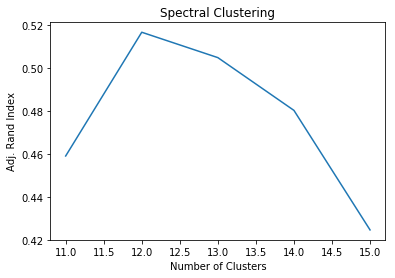

In [66]:
x_data = [ 11, 12, 13, 14, 15 ]
y_data = [ tfidf_sc_ari11, tfidf_sc_ari12, tfidf_sc_ari13, tfidf_sc_ari14, tfidf_sc_ari15 ]

plt.plot(x_data, y_data)
plt.title('Spectral Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Adj. Rand Index')

plt.show()

Although there were in fact 13 different authors represented, Spectral Clustering performed slightly better when number of clusters was set to 12. However, the difference was just over 0.01 so only representative of a few changes. Conversely, increasing or decreasing number of clusters further caused a significant reduction of ARI.

#### Linear SVC

In [67]:
print('tf-idf Linear SVC:')
tfidf_svc = LinearSVC()
tfidf_svc_train = tfidf_svc.fit(tfidf_train_out, Y_train)

Y_pred = tfidf_svc.predict(tfidf_test_out)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
tfidf_svc_test_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

tf-idf Linear SVC:
              precision    recall  f1-score   support

      780903       1.00      0.80      0.89         5
     3305548       0.83      1.00      0.90        19
     2155904       1.00      1.00      1.00         3
     1474573       1.00      1.00      1.00         5
     4161674       0.75      1.00      0.86         3
     2314011       0.82      0.90      0.86        10
     1889734       1.00      0.70      0.82        10
      670684       1.00      1.00      1.00         9
     1593902       1.00      0.80      0.89         5
     2128831       1.00      1.00      1.00        33
     1516660       1.00      1.00      1.00         6
     2862338       1.00      0.83      0.91        12
     2587254       0.60      0.75      0.67         4

    accuracy                           0.93       124
   macro avg       0.92      0.91      0.91       124
weighted avg       0.94      0.93      0.93       124



In [68]:
tfidf_svc.get_params

<bound method BaseEstimator.get_params of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)>

Initial accuracy and weighted F1 score is 0.93 using C=1.0 and tol=0.0001.

In [69]:
from sklearn.model_selection import GridSearchCV

tfidf_svc = LinearSVC()

C_set = [ 0.001, 0.01, 1, 10, 100, 1000 ]
tol_set = [ 1e-4, 1e-3, 1e-2, 1e-1, 1 ]
grid_values = {'C': C_set, 'tol': tol_set }

svc_fit = GridSearchCV(tfidf_svc, param_grid = grid_values,
                       cv=5,iid=True,n_jobs=-1).fit(tfidf_train_out, Y_train)

In [70]:
Y_pred = svc_fit.best_estimator_.predict(tfidf_test_out)
print(classification_report(Y_test, Y_pred, target_names=blogger_ids))
tfidf_svc_test_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

              precision    recall  f1-score   support

      780903       1.00      0.80      0.89         5
     3305548       0.90      1.00      0.95        19
     2155904       1.00      1.00      1.00         3
     1474573       1.00      1.00      1.00         5
     4161674       0.60      1.00      0.75         3
     2314011       0.90      0.90      0.90        10
     1889734       1.00      0.70      0.82        10
      670684       1.00      1.00      1.00         9
     1593902       1.00      0.80      0.89         5
     2128831       1.00      1.00      1.00        33
     1516660       1.00      1.00      1.00         6
     2862338       1.00      0.92      0.96        12
     2587254       0.67      1.00      0.80         4

    accuracy                           0.94       124
   macro avg       0.93      0.93      0.92       124
weighted avg       0.96      0.94      0.94       124



In [71]:
svc_fit.best_params_

{'C': 10, 'tol': 0.1}

By increasing C to 1000 and tol to 0.1, there is a slight increase in both accuracy and weighted F1 score but the difference is only from 0.93 to 0.94. F1 score decreases for one author (4161674) but increases for four (3305548, 2314011, 2862338 and 2587254). Support for that one author is only 3 compared to 19, 10, 12 and 4 for the four improved authors, suggesting that this is a good trade off.

## Holdout Comparison

#### Spectral Clustering

Compare behavior of Spectral Clustering applied to the training set and the test (holdout set).

In [72]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=13, random_state=42, n_jobs=-1)
sc.fit(tfidf_test_out)

#Predict clusters
tfidf_test_pred = sc.fit_predict(tfidf_test_out)

# Check actual vs predicted
print(pd.crosstab(Y_test,tfidf_test_pred))

tfidf_sc_test_ari13 = metrics.adjusted_rand_score(Y_test, tfidf_test_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_test_ari13))

col_0    0   1   2   3   4   5   6   7   8   9   10  11  12
id                                                         
670684    0   0   3   1   0   0   0   0   0   0   0   0   1
780903    0   0   0   2   0  13   0   0   0   0   1   0   3
1474573   0   0   0   0   0   0   1   0   0   0   0   0   2
1516660   0   0   0   0   0   0   0   0   0   0   0   5   0
1593902   0   0   0   0   0   0   0   0   0   0   0   0   3
1889734   0   0   0   2   0   0   0   0   0   0   8   0   0
2128831   0   0   2   0   0   0   6   0   0   0   1   0   1
2155904   0   0   0   0   0   0   0   9   0   0   0   0   0
2314011   0   0   3   0   0   0   1   0   0   0   1   0   0
2587254  12   0   0   0  10   0   0   0   0  11   0   0   0
2862338   0   5   0   0   0   0   0   0   0   0   0   0   1
3305548   0   0   0   2   0   0   0   0  10   0   0   0   0
4161674   0   0   0   0   0   0   1   0   0   0   3   0   0
ARI for Spectral Clustering tf-idf is: 0.487251194879965


In [73]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=12, random_state=42, n_jobs=-1)
sc.fit(tfidf_test_out)

#Predict clusters
tfidf_test_pred = sc.fit_predict(tfidf_test_out)

# Check actual vs predicted
print(pd.crosstab(Y_test,tfidf_test_pred))

tfidf_sc_test_ari12 = metrics.adjusted_rand_score(Y_test, tfidf_test_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_test_ari12))

col_0    0   1   2   3   4   5   6   7   8   9   10  11
id                                                     
670684    0   0   3   0   0   0   0   0   0   1   0   1
780903    0   0   0   0   0   0   0   0   1   2  13   3
1474573   0   1   0   0   0   0   0   0   0   0   0   2
1516660   0   0   0   0   0   0   5   0   0   0   0   0
1593902   0   0   0   0   0   0   0   0   0   0   0   3
1889734   0   0   0   0   0   0   0   0   8   2   0   0
2128831   0   0   8   0   0   0   0   0   1   0   0   1
2155904   0   0   0   0   9   0   0   0   0   0   0   0
2314011   0   0   4   0   0   0   0   0   0   0   0   1
2587254  11  12   0   0   0   0   0  10   0   0   0   0
2862338   0   0   0   5   0   0   0   0   0   0   0   1
3305548   0   0   0   0   0  10   0   0   0   2   0   0
4161674   0   0   1   0   0   0   0   0   3   0   0   0
ARI for Spectral Clustering tf-idf is: 0.47985993538017774


In [74]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=11, random_state=42, n_jobs=-1)
sc.fit(tfidf_test_out)

#Predict clusters
tfidf_test_pred = sc.fit_predict(tfidf_test_out)

# Check actual vs predicted
print(pd.crosstab(Y_test,tfidf_test_pred))

tfidf_sc_test_ari11 = metrics.adjusted_rand_score(Y_test, tfidf_test_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_test_ari11))

col_0    0   1   2   3   4   5   6   7   8   9   10
id                                                 
670684    0   1   0   0   1   0   0   0   0   3   0
780903    0   3   0   0   3  13   0   0   0   0   0
1474573   0   2   0   0   0   0   0   0   1   0   0
1516660   0   0   0   0   0   0   0   5   0   0   0
1593902   0   3   0   0   0   0   0   0   0   0   0
1889734   0   0   0   2   7   0   0   0   0   1   0
2128831   0   1   0   0   0   0   0   0   0   9   0
2155904   0   0   0   0   0   0   9   0   0   0   0
2314011   0   0   0   0   0   0   0   0   0   5   0
2587254   0   0   9   0   0   0   0   0  12   0  12
2862338   5   1   0   0   0   0   0   0   0   0   0
3305548   0   0   0  10   2   0   0   0   0   0   0
4161674   0   0   0   0   2   0   0   0   0   2   0
ARI for Spectral Clustering tf-idf is: 0.4547295613488127


In [75]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=14, random_state=42, n_jobs=-1)
sc.fit(tfidf_test_out)

#Predict clusters
tfidf_test_pred = sc.fit_predict(tfidf_test_out)

# Check actual vs predicted
print(pd.crosstab(Y_test,tfidf_test_pred))

tfidf_sc_test_ari14 = metrics.adjusted_rand_score(Y_test, tfidf_test_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_test_ari14))

col_0    0   1   2   3   4   5   6   7   8   9   10  11  12  13
id                                                             
670684    3   0   0   0   0   0   0   0   0   1   1   0   0   0
780903    0   2   0   0   0   0   0   9   0   2   2   4   0   0
1474573   0   0   0   0   0   0   0   1   0   0   2   0   0   0
1516660   0   0   0   0   5   0   0   0   0   0   0   0   0   0
1593902   0   0   0   0   0   0   0   0   0   0   3   0   0   0
1889734   0   1   0   0   0   0   0   0   0   2   0   0   0   7
2128831   0  10   0   0   0   0   0   0   0   0   0   0   0   0
2155904   0   0   9   0   0   0   0   0   0   0   0   0   0   0
2314011   3   2   0   0   0   0   0   0   0   0   0   0   0   0
2587254   0   0   0   0   0  12  10   0   0   0   0   0  11   0
2862338   0   0   0   0   0   0   0   0   6   0   0   0   0   0
3305548   0   0   0  10   0   0   0   0   0   2   0   0   0   0
4161674   0   2   0   0   0   0   0   0   0   0   0   0   0   2
ARI for Spectral Clustering tf-idf is: 0

In [76]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=15, random_state=42, n_jobs=-1)
sc.fit(tfidf_test_out)

#Predict clusters
tfidf_test_pred = sc.fit_predict(tfidf_test_out)

# Check actual vs predicted
print(pd.crosstab(Y_test,tfidf_test_pred))

tfidf_sc_test_ari15 = metrics.adjusted_rand_score(Y_test, tfidf_test_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_test_ari15))

col_0    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
id                                                                 
670684    0   0   0   0   0   0   0   0   0   1   0   0   0   1   3
780903    0   0   0   0   0   0   0   4   5   2   0   0   8   0   0
1474573   0   0   0   0   0   0   0   0   0   1   0   0   0   2   0
1516660   0   0   0   0   0   0   0   0   0   0   5   0   0   0   0
1593902   0   0   0   0   0   0   0   2   0   0   0   0   0   1   0
1889734   0   1   0   0   7   0   0   0   0   2   0   0   0   0   0
2128831   0   9   0   0   0   0   0   1   0   0   0   0   0   0   0
2155904   0   0   0   0   0   0   9   0   0   0   0   0   0   0   0
2314011   0   4   0   0   0   0   0   0   1   0   0   0   0   0   0
2587254   8   0  12   0   0  12   0   0   0   0   0   0   1   0   0
2862338   0   0   0   0   0   0   0   0   0   0   0   5   0   1   0
3305548   0   0   0  10   0   0   0   0   0   2   0   0   0   0   0
4161674   0   1   0   0   2   0   0   1   0   0 

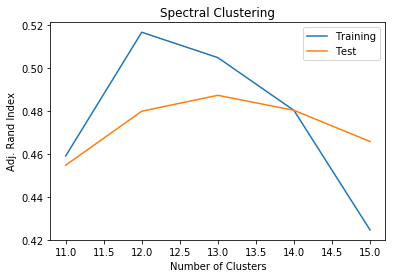

In [77]:
x_data = [ 11, 12, 13, 14, 15 ]
y_test_data = [ tfidf_sc_test_ari11, tfidf_sc_test_ari12, tfidf_sc_test_ari13,
          tfidf_sc_test_ari14, tfidf_sc_test_ari15 ]

plt.plot(x_data, y_data, label='Training')
plt.plot(x_data, y_test_data, label='Test')
plt.title('Spectral Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Adj. Rand Index')
plt.legend()
plt.show()

Although the ARI for Spectral Clustering dropped a little bit switching from the training set to the test set, it was still above 0.48. In addition, it was fairly stable when changing number of clusters with ARI gradually decreasing and number of clusters was either increased or decreased (the peak was at 13 for the test set).

#### Linear SVC

Fit a Linear SVC model to the test set and compare performance when trying to predict training set.

In [78]:
tfidf_svc = LinearSVC()

C_set = [ 0.001, 0.01, 1, 10, 100, 1000 ]
tol_set = [ 1e-4, 1e-3, 1e-2, 1e-1, 1 ]
grid_values = {'C': C_set, 'tol': tol_set }

svc_test_fit = GridSearchCV(tfidf_svc, param_grid = grid_values,
                       cv=5,iid=True,n_jobs=-1).fit(tfidf_test_out, Y_test)

In [79]:
Y_pred = svc_test_fit.best_estimator_.predict(tfidf_train_out)
print(classification_report(Y_train, Y_pred, target_names=blogger_ids))
tfidf_svc_test_score = metrics.f1_score(Y_train, Y_pred, average='weighted')

              precision    recall  f1-score   support

      780903       1.00      0.29      0.45        17
     3305548       0.61      1.00      0.76        53
     2155904       1.00      0.05      0.10        19
     1474573       1.00      0.97      0.98        30
     4161674       1.00      0.05      0.09        22
     2314011       0.60      0.81      0.69        32
     1889734       0.44      0.73      0.55        22
      670684       1.00      0.97      0.99        40
     1593902       1.00      0.67      0.80        18
     2128831       0.88      1.00      0.94        66
     1516660       0.90      0.90      0.90        20
     2862338       0.53      0.91      0.67        11
     2587254       1.00      0.15      0.26        20

    accuracy                           0.75       370
   macro avg       0.84      0.65      0.63       370
weighted avg       0.84      0.75      0.71       370



Accuracy and weighted F1 score decrease considerably when using the test set to fit a new Linear SVC model. However, whereas the original model had 370 points on which to fit, the test set only has 124 points so a decrease in performance would be expected. There are a few instances of low precision or recall but the majority of authors still have F1 scores above 0.7.

## Conclusions

Using two component PCA, charts will be generated to compare the actual author ID's with Spectral Clustering and Linear SVC predictions.

#### Training data comparison

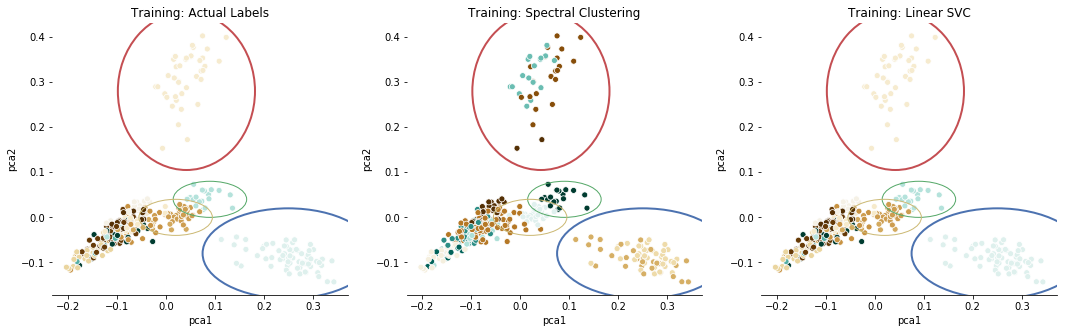

In [80]:
tfidf_chart = pd.DataFrame()
tfidf_chart['pca1'] = pca_tfidf_train2[:,0]
tfidf_chart['pca2'] = pca_tfidf_train2[:,1]
tfidf_chart['id'] = Y_train.values

sc = SpectralClustering(n_clusters=12, random_state=42, n_jobs=-1)
tfidf_chart['sc_pred'] = sc.fit_predict(tfidf_train_out)

tfidf_chart['svc_pred'] = svc_fit.best_estimator_.predict(tfidf_train_out)

import matplotlib.patches as patches

f, axes = plt.subplots(1, 3, figsize=(18,5), sharex=False)
sns.despine(left=True)

sns.scatterplot(x='pca1', y='pca2', hue='id', data=tfidf_chart, palette='BrBG',
                legend=None, ax=axes[0]).set_title('Training: Actual Labels')
sns.scatterplot(x='pca1', y='pca2', hue='sc_pred', data=tfidf_chart, palette='BrBG',
                legend=None, ax=axes[1]).set_title('Training: Spectral Clustering')
sns.scatterplot(x='pca1', y='pca2', hue='svc_pred', data=tfidf_chart, palette='BrBG',
                legend=None, ax=axes[2]).set_title('Training: Linear SVC')

ellipse1 = patches.Ellipse((0.042,0.28),0.28,0.35,
                           linewidth=2,edgecolor='r',facecolor='none', angle=0)
ellipse2 = patches.Ellipse((0.25,-0.08),0.35,0.2,
                           linewidth=2,edgecolor='b',facecolor='none', angle=0)
ellipse3 = patches.Ellipse((0.09,0.04),0.15,0.08,
                           linewidth=1,edgecolor='g',facecolor='none', angle=0)
ellipse4 = patches.Ellipse((0.02,0.0),0.15,0.08,
                           linewidth=1,edgecolor='y',facecolor='none', angle=0)

axes[0].add_patch(ellipse1)
axes[0].add_patch(ellipse2)
axes[0].add_patch(ellipse3)
axes[0].add_patch(ellipse4)

ellipse1 = patches.Ellipse((0.042,0.28),0.28,0.35,
                           linewidth=2,edgecolor='r',facecolor='none', angle=0)
ellipse2 = patches.Ellipse((0.25,-0.08),0.35,0.2,
                           linewidth=2,edgecolor='b',facecolor='none', angle=0)
ellipse3 = patches.Ellipse((0.09,0.04),0.15,0.08,
                           linewidth=1,edgecolor='g',facecolor='none', angle=0)
ellipse4 = patches.Ellipse((0.02,0.0),0.15,0.08,
                           linewidth=1,edgecolor='y',facecolor='none', angle=0)

axes[1].add_patch(ellipse1)
axes[1].add_patch(ellipse2)
axes[1].add_patch(ellipse3)
axes[1].add_patch(ellipse4)

ellipse1 = patches.Ellipse((0.042,0.28),0.28,0.35,
                           linewidth=2,edgecolor='r',facecolor='none', angle=0)
ellipse2 = patches.Ellipse((0.25,-0.08),0.35,0.2,
                           linewidth=2,edgecolor='b',facecolor='none', angle=0)
ellipse3 = patches.Ellipse((0.09,0.04),0.15,0.08,
                           linewidth=1,edgecolor='g',facecolor='none', angle=0)
ellipse4 = patches.Ellipse((0.02,0.0),0.15,0.08,
                           linewidth=1,edgecolor='y',facecolor='none', angle=0)

axes[2].add_patch(ellipse1)
axes[2].add_patch(ellipse2)
axes[2].add_patch(ellipse3)
axes[2].add_patch(ellipse4)

plt.show()

PCA Observations:
- The PCA transformation seems to have created three larger clusters
- The top and right clusters consist of individual authors
- The left cluster is a mix of all of the others
 - There do appear to be a couple of smaller clusters separated within the left cluster
 - Remaining labels appear to be mixed
 
Spectral Clustering Observations:
- The top and right clusters are incorrectly divided into two authors each
- The two smaller clusters appear to be consistent
- The remaining data appear to be loosely grouped in clusters, moreso than the original data. Considering clustering was done upon the full data set but is being shown here PCA-transformed, this suggests that some of the effects of PCA are overlapping with Spectral Clustering.

Linear SVC Observations:
- All four of the clusters that could be clearly identified in the original data are correctly identified
- The remaining data appear jumbled, as they do in the original data. It is difficult to tell which points may match but this is due to two component-PCA not being able to fully explain variance. If a higher dimensional set were used, it might become easier to differentiate clusters but visualization complexity would increase significantly.

#### Test data comparison

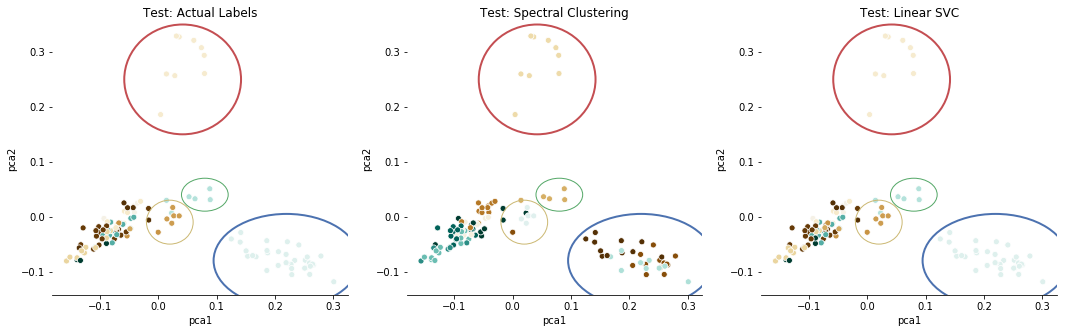

In [81]:
del tfidf_chart
tfidf_chart = pd.DataFrame()
tfidf_chart['pca1'] = pca_tfidf_test2[:,0]
tfidf_chart['pca2'] = pca_tfidf_test2[:,1]
tfidf_chart['id'] = Y_test.values

sc = SpectralClustering(n_clusters=12, random_state=42, n_jobs=-1)
tfidf_chart['sc_pred'] = sc.fit_predict(tfidf_test_out)

tfidf_chart['svc_pred'] = svc_fit.best_estimator_.predict(tfidf_test_out)

f, axes = plt.subplots(1, 3, figsize=(18,5), sharex=False)
sns.despine(left=True)

sns.scatterplot(x='pca1', y='pca2', hue='id', data=tfidf_chart, palette='BrBG',
                legend=None, ax=axes[0]).set_title('Test: Actual Labels')
sns.scatterplot(x='pca1', y='pca2', hue='sc_pred', data=tfidf_chart, palette='BrBG',
                legend=None, ax=axes[1]).set_title('Test: Spectral Clustering')
sns.scatterplot(x='pca1', y='pca2', hue='svc_pred', data=tfidf_chart, palette='BrBG',
                legend=None, ax=axes[2]).set_title('Test: Linear SVC')

ellipse1 = patches.Ellipse((0.042,0.25),0.2,0.2,
                           linewidth=2,edgecolor='r',facecolor='none', angle=0)
ellipse2 = patches.Ellipse((0.22,-0.08),0.25,0.17,
                           linewidth=2,edgecolor='b',facecolor='none', angle=0)
ellipse3 = patches.Ellipse((0.08,0.04),0.08,0.06,
                           linewidth=1,edgecolor='g',facecolor='none', angle=0)
ellipse4 = patches.Ellipse((0.02,-0.01),0.08,0.08,
                           linewidth=1,edgecolor='y',facecolor='none', angle=0)

axes[0].add_patch(ellipse1)
axes[0].add_patch(ellipse2)
axes[0].add_patch(ellipse3)
axes[0].add_patch(ellipse4)

ellipse1 = patches.Ellipse((0.042,0.25),0.2,0.2,
                           linewidth=2,edgecolor='r',facecolor='none', angle=0)
ellipse2 = patches.Ellipse((0.22,-0.08),0.25,0.17,
                           linewidth=2,edgecolor='b',facecolor='none', angle=0)
ellipse3 = patches.Ellipse((0.08,0.04),0.08,0.06,
                           linewidth=1,edgecolor='g',facecolor='none', angle=0)
ellipse4 = patches.Ellipse((0.02,-0.01),0.08,0.08,
                           linewidth=1,edgecolor='y',facecolor='none', angle=0)

axes[1].add_patch(ellipse1)
axes[1].add_patch(ellipse2)
axes[1].add_patch(ellipse3)
axes[1].add_patch(ellipse4)

ellipse1 = patches.Ellipse((0.042,0.25),0.2,0.2,
                           linewidth=2,edgecolor='r',facecolor='none', angle=0)
ellipse2 = patches.Ellipse((0.22,-0.08),0.25,0.17,
                           linewidth=2,edgecolor='b',facecolor='none', angle=0)
ellipse3 = patches.Ellipse((0.08,0.04),0.08,0.06,
                           linewidth=1,edgecolor='g',facecolor='none', angle=0)
ellipse4 = patches.Ellipse((0.02,-0.01),0.08,0.08,
                           linewidth=1,edgecolor='y',facecolor='none', angle=0)

axes[2].add_patch(ellipse1)
axes[2].add_patch(ellipse2)
axes[2].add_patch(ellipse3)
axes[2].add_patch(ellipse4)

plt.show()

The behavior seen in the test set is similar to that from the training set, although Spectral Clustering correctly identifies a single author in the top cluster rather than two in the training set. It does still incorrectly split the right cluster into two. This suggests that both models are relatively stable.

#### Final Thoughts

This report investigated classification of blog posts by authors, comparing different NLP vectorization methods, clustering methods, unsupervised dimension reduction techniques and supervised learning models.
- Both Bag of Words (BoW) and Term Frequency-Inverse Document Frequency (tf-idf) vectorization performed relatively well but tf-idf was generally better.
- K-Means and Spectral Clustering were both able to classify authors but Mean-Shift was not. Spectral Clustering performed better for both BoW and tf-idf.
- Both PCA and truncated SVD were used to reduce dimensionality and both required a fairly large number of components to reach 80% variance explained. However, they were still able to reduce dimensions from about 25k to less than 100.
- Random Forest, Linear SVC and Gradient Boosting models (using both original data and reduced data) all yielded weighted F1 Scores above 0.60. Although BoW Random Forest w/ PCA performed best, Linear SVC (w/ and w/o LSA) was most consistent.
- Spectral Clustering and Linear SVC models were able to classify blog posts well but Linear SVC reached 0.94 accuracy and 0.94 weighted F-Score after applying grid search optimization. From a visual comparison using 2 component PCA scatter plots, the Linear SVC plot looked most similar to actual.
- With this set of data, technical performance was not an issue but if a larger data set were used, runtime might become a consideration. In terms of optimization, clustering is probably less computationally intensive.
- While class imbalance impacts both clustering and supervised learning models, some clustering methods operate under the assumption of equal class size so may not be applicable to all data sets.